In [1]:
%matplotlib inline

import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('./data/tweets.csv')
df.head()

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@hdgolfblake,"Fred Garvin, MP","Mar 23, 2022",NaN,"healthy,Thankful",en,5.0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"It's been 39 months, 14 MRIs and way too many ...",3:35 PM
1,@joysmile0903,tweetjoy,"Mar 23, 2022",NaN,"JOY,조이,RedVelvet,레드벨벳",th,2.0,NaN,RVsmtown0,0.0,3.0,positive,Twitter Web App,ดูความอ่อนช้อย ความสมูทในการเอียงคอของจอยในท่อ...,4:36 PM
2,@flexydamy,Fortunate Damilola,"Mar 23, 2022",NaN,"GDC2022,GDC,Fortunate,Creative",en,0.0,NaN,Miunify,0.0,0.0,positive,Twitter for Android,"Wk 3 Day 3, Come up with Twitter simple flyer,...",2:17 AM
3,@mackierolls,Mackie,"Mar 23, 2022",NaN,"thankful,learning,academia",en,13.0,NaN,NaN,0.0,0.0,positive,Twitter Web App,had a pretty shitty day today but it's always ...,1:14 PM
4,@c2clady,Julia Manners,"Mar 23, 2022",NaN,"thankful,goodnessofGod",en,0.0,"Jericho, NY",NaN,0.0,0.0,positive,"Jericho, NY",#thankful #goodnessofGod,11:55 AM


In [3]:
df.shape

(1768, 15)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
emails,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
likes,1442.0,2.321082,9.579802,0.0,0.0,0.0,0.0,165.0
quotes,1442.0,0.042302,0.702143,0.0,0.0,0.0,0.0,23.0
retweets,1442.0,0.455617,2.399638,0.0,0.0,0.0,0.0,42.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    1768 non-null   object 
 1   author_name  1768 non-null   object 
 2   date         1442 non-null   object 
 3   emails       0 non-null      float64
 4   hashtags     1401 non-null   object 
 5   language     1439 non-null   object 
 6   likes        1442 non-null   float64
 7   location     45 non-null     object 
 8   mentions     326 non-null    object 
 9   quotes       1442 non-null   float64
 10  retweets     1442 non-null   float64
 11  sentiment    1439 non-null   object 
 12  source       1442 non-null   object 
 13  text         1440 non-null   object 
 14  time         1442 non-null   object 
dtypes: float64(4), object(11)
memory usage: 207.3+ KB


In [6]:
# Remove rows without sentiment
df = df.dropna(subset=['sentiment'])
df = df.reset_index(drop=True)
df

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@hdgolfblake,"Fred Garvin, MP","Mar 23, 2022",NaN,"healthy,Thankful",en,5.0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"It's been 39 months, 14 MRIs and way too many ...",3:35 PM
1,@joysmile0903,tweetjoy,"Mar 23, 2022",NaN,"JOY,조이,RedVelvet,레드벨벳",th,2.0,NaN,RVsmtown0,0.0,3.0,positive,Twitter Web App,ดูความอ่อนช้อย ความสมูทในการเอียงคอของจอยในท่อ...,4:36 PM
2,@flexydamy,Fortunate Damilola,"Mar 23, 2022",NaN,"GDC2022,GDC,Fortunate,Creative",en,0.0,NaN,Miunify,0.0,0.0,positive,Twitter for Android,"Wk 3 Day 3, Come up with Twitter simple flyer,...",2:17 AM
3,@mackierolls,Mackie,"Mar 23, 2022",NaN,"thankful,learning,academia",en,13.0,NaN,NaN,0.0,0.0,positive,Twitter Web App,had a pretty shitty day today but it's always ...,1:14 PM
4,@c2clady,Julia Manners,"Mar 23, 2022",NaN,"thankful,goodnessofGod",en,0.0,"Jericho, NY",NaN,0.0,0.0,positive,"Jericho, NY",#thankful #goodnessofGod,11:55 AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,@Smriti1999,Smriti,"Mar 23, 2022",NaN,"depressed,attacks,bullying,society,compensate",en,0.0,NaN,"aajtak,ndtv,ZeeNews,ABPNews,indiaaheadhindi",0.0,0.0,negative,Twitter for iPhone,#FMWangYiSaveIndianStudents students among us ...,6:37 AM
1435,@GiaBermudez,Gianny Bermúdez,"Mar 23, 2022",NaN,sad,es,0.0,NaN,NaN,0.0,0.0,negative,Twitter Web App,"Mrk se retiró daddy Yankee, y el tipo aún está...",1:22 PM
1436,@poligrafnews,Poligraf.News,"Mar 23, 2022",NaN,"mars,sad",hr,0.0,NaN,NaN,0.0,0.0,negative,testAstrosav,Je li savez Rusije i Kine protiv SAD prazna pr...,8:37 AM
1437,@xstallingsx,Stallings,"Mar 22, 2022",NaN,"depressed,lonely,sadboy",en,0.0,NaN,NaN,0.0,0.0,negative,Twitter for iPhone,Hold me till I’m not lonely anymore 😢\n\n#depr...,2:48 PM


In [7]:
# Remove rows if language is not english
df = df[df['language'].isin(['en'])]
df = df.reset_index(drop=True)
df

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@hdgolfblake,"Fred Garvin, MP","Mar 23, 2022",NaN,"healthy,Thankful",en,5.0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"It's been 39 months, 14 MRIs and way too many ...",3:35 PM
1,@flexydamy,Fortunate Damilola,"Mar 23, 2022",NaN,"GDC2022,GDC,Fortunate,Creative",en,0.0,NaN,Miunify,0.0,0.0,positive,Twitter for Android,"Wk 3 Day 3, Come up with Twitter simple flyer,...",2:17 AM
2,@mackierolls,Mackie,"Mar 23, 2022",NaN,"thankful,learning,academia",en,13.0,NaN,NaN,0.0,0.0,positive,Twitter Web App,had a pretty shitty day today but it's always ...,1:14 PM
3,@c2clady,Julia Manners,"Mar 23, 2022",NaN,"thankful,goodnessofGod",en,0.0,"Jericho, NY",NaN,0.0,0.0,positive,"Jericho, NY",#thankful #goodnessofGod,11:55 AM
4,@tusparkogebe,Tuspark Ogebe -IG,"Mar 23, 2022",NaN,"thankful,davido",en,0.0,NaN,NaN,0.0,0.0,positive,Twitter for iPhone,Jesus ogbenjuwa #thankful\n\n#davido 3 weeks t...,1:39 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,@AnilKat27138460,Anil Katara,"Mar 23, 2022",NaN,"Sindhis,Karachi,partition,Hindu,sad,true",en,3.0,NaN,NaN,0.0,4.0,negative,Twitter Web App,Same process was enacted upon #Sindhis of #Kar...,4:15 AM
1213,@DocSharkey,John White,"Mar 19, 2022",NaN,"physicians,suicidal",en,0.0,NaN,NaN,0.0,0.0,negative,Twitter Web App,https://mayoclinicproceedings.org/article/S002...,7:54 PM
1214,@bbouton,TheBouton,"Mar 23, 2022",NaN,"sadQuote,ScottBaio,ErinMoran",en,0.0,NaN,"ScottBaio,SilverAgeTV",0.0,0.0,negative,Twitter Web App,and this would be the end of @ScottBaio's rele...,2:35 PM
1215,@Smriti1999,Smriti,"Mar 23, 2022",NaN,"depressed,attacks,bullying,society,compensate",en,0.0,NaN,"aajtak,ndtv,ZeeNews,ABPNews,indiaaheadhindi",0.0,0.0,negative,Twitter for iPhone,#FMWangYiSaveIndianStudents students among us ...,6:37 AM


In [8]:
# Check number of rows for each sentiment
df['sentiment'].value_counts()

neutral     574
negative    543
positive    100
Name: sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

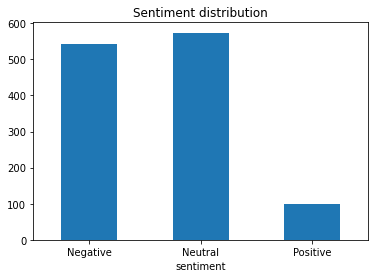

In [13]:
# Display sentiment data distribution
sentiment_text_df = df[['sentiment', 'text']]
ax = sentiment_text_df.groupby('sentiment').count().plot(kind='bar', title='Sentiment distribution', legend=False)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
word_lemmatizer = WordNetLemmatizer()

EMAIL_PATTERN = re.compile(
    r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)'
)

MENTION_PATTERN = re.compile(r'(^|[^@\w])@(\w{1,15})\b')

HASHTAG_PATTERN = re.compile(r'(^|[^@\w])#(\w{1,15})\b')

URL_PATTERN = re.compile(r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)')

NON_ALPHA_PATTERN = re.compile('[^a-zA-Z0-9]')

SEQUENCE_PATTERN = re.compile(r'(.)\1\1+')

SEQUENCE_REPLACE_PATTERN = r'\1\1'


def replace_emails(text):
    return re.sub(EMAIL_PATTERN, ' email', text)


def replace_mentions(text):
    return re.sub(MENTION_PATTERN, ' mention', text)


def replace_hashtags(text):
    return re.sub(HASHTAG_PATTERN, ' hashtag', text)


def replace_urls(text):
    return re.sub(URL_PATTERN, ' URL', text)


def replace_non_alphas(text):
    return re.sub(NON_ALPHA_PATTERN, ' ', text)


def replace_sequences(text):
    return re.sub(SEQUENCE_PATTERN, SEQUENCE_REPLACE_PATTERN, text)


def replace_stop_words(text):
    words = ''
    
    for word in text.split():
        should_include = True
        for stop_word in stop_words:
            if word in stop_words or not len(word):
                should_include = False
                
        if should_include:
            word = word_lemmatizer.lemmatize(word)
            words += f'{word} '
                
    return words
        
df['text'] = df['text'].map(lambda text: text.lower())
df['text'] = df['text'].map(lambda text: replace_emails(text))
df['text'] = df['text'].map(lambda text: replace_mentions(text))
df['text'] = df['text'].map(lambda text: replace_hashtags(text))
df['text'] = df['text'].map(lambda text: replace_urls(text))
df['text'] = df['text'].map(lambda text: replace_non_alphas(text))
df['text'] = df['text'].map(lambda text: replace_sequences(text))
df['text'] = df['text'].map(lambda text: replace_stop_words(text))

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szymwisn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/szymwisn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@hdgolfblake,"Fred Garvin, MP","Mar 23, 2022",NaN,"healthy,Thankful",en,5.0,NaN,NaN,0.0,0.0,positive,Twitter for Android,39 month 14 mri way many appointment today day...,3:35 PM
1,@flexydamy,Fortunate Damilola,"Mar 23, 2022",NaN,"GDC2022,GDC,Fortunate,Creative",en,0.0,NaN,Miunify,0.0,0.0,positive,Twitter for Android,wk 3 day 3 come twitter simple flyer announce ...,2:17 AM
2,@mackierolls,Mackie,"Mar 23, 2022",NaN,"thankful,learning,academia",en,13.0,NaN,NaN,0.0,0.0,positive,Twitter Web App,pretty shitty day today always best feeling en...,1:14 PM
3,@c2clady,Julia Manners,"Mar 23, 2022",NaN,"thankful,goodnessofGod",en,0.0,"Jericho, NY",NaN,0.0,0.0,positive,"Jericho, NY",hashtag hashtag,11:55 AM
4,@tusparkogebe,Tuspark Ogebe -IG,"Mar 23, 2022",NaN,"thankful,davido",en,0.0,NaN,NaN,0.0,0.0,positive,Twitter for iPhone,jesus ogbenjuwa hashtag hashtag 3 week go,1:39 PM


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    1217 non-null   object 
 1   author_name  1217 non-null   object 
 2   date         1217 non-null   object 
 3   emails       0 non-null      float64
 4   hashtags     1181 non-null   object 
 5   language     1217 non-null   object 
 6   likes        1217 non-null   float64
 7   location     40 non-null     object 
 8   mentions     298 non-null    object 
 9   quotes       1217 non-null   float64
 10  retweets     1217 non-null   float64
 11  sentiment    1217 non-null   object 
 12  source       1217 non-null   object 
 13  text         1217 non-null   object 
 14  time         1217 non-null   object 
dtypes: float64(4), object(11)
memory usage: 142.7+ KB


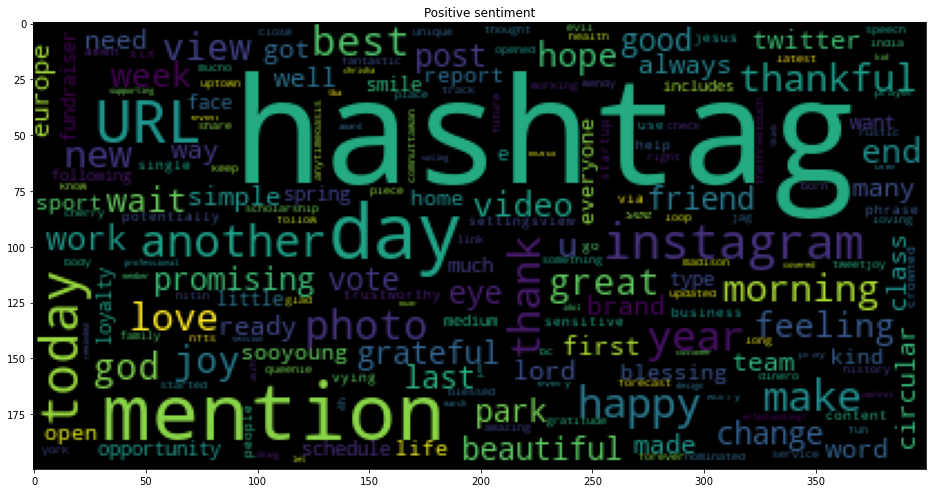

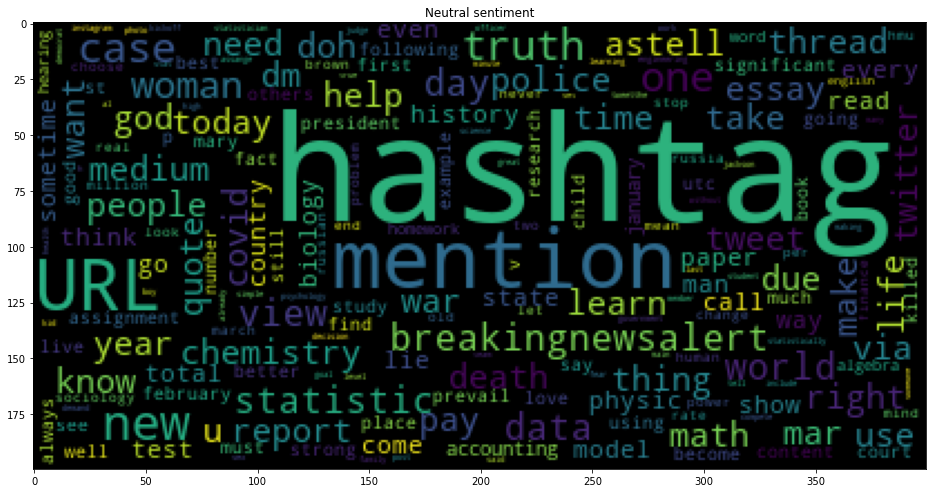

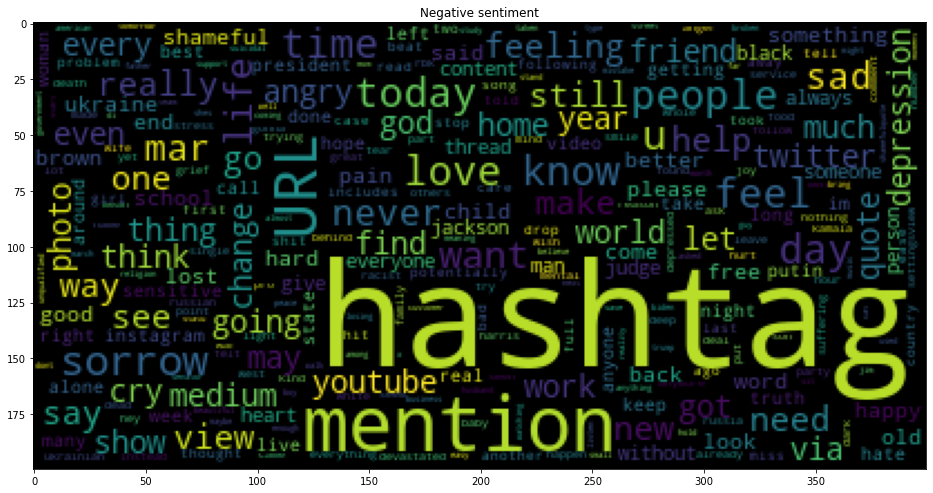

In [12]:
df_positive_text = ' '.join(df.query('sentiment==\'positive\'')['text'])
df_negative_text = ' '.join(df.query('sentiment==\'negative\'')['text'])
df_neutral_text = ' '.join(df.query('sentiment==\'neutral\'')['text'])

def print_word_cloud(title, text):
    plt.figure(figsize=(16, 16))
    wc = WordCloud(max_words=1000, collocations=False).generate(text)
    plt.title(title)
    plt.imshow(wc)
    
# Display word clouds
print_word_cloud('Positive sentiment', df_positive_text)
print_word_cloud('Neutral sentiment', df_neutral_text)
print_word_cloud('Negative sentiment', df_negative_text)